In [1]:
from collections import defaultdict
from typing import Callable

import matplotlib.pyplot as plt
import numpy as np
import sklearn.datasets
from modAL.batch import uncertainty_batch_sampling
from modAL.models import ActiveLearner
from modAL.uncertainty import (entropy_sampling, margin_sampling,
                               uncertainty_sampling)
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold


%matplotlib inline

# Training Curve Utils

In [2]:
def train_curve_random(
    X_train: np.ndarray,
    y_train: np.ndarray,
    X_valid: np.ndarray,
    y_valid: np.ndarray,
    model_factory: Callable,
    train_sizes: list[int],
) -> list[float]:
    """Compute test score for various train set sizes, using random sampling"""
    scores = list()

    for train_size in train_sizes:
        model = model_factory()
        model.fit(X_train[:train_size], y_train[:train_size])
        scores.append(accuracy_score(y_valid, model.predict(X_valid)))

    return scores

In [3]:
def train_curve_active(
    X_train: np.ndarray,
    y_train: np.ndarray,
    X_valid: np.ndarray,
    y_valid: np.ndarray,
    model_factory: Callable,
    train_sizes: list[int],
    query_strategy: Callable,
) -> list[float]:
    """Compute test score for various train set sizes, using active learning"""
    scores = list()
    n_initial = train_sizes[0]

    model = get_model()

    learner = ActiveLearner(
        estimator=model,
        query_strategy=query_strategy,
        X_training=X_train[:n_initial],
        y_training=y_train[:n_initial],
    )

    X_pool, y_pool = X_train[n_initial:], y_train[n_initial:]
    for i in range(n_initial, max(train_sizes) + 1):
        if i in train_sizes:
            scores.append(learner.score(X_valid, y_valid))
            print(f"  - {i}")

        query_idx, query_inst = learner.query(X_pool)
        y_new = y_pool[query_idx[0]]
        learner.teach(query_inst.reshape(1, -1), [y_new])
        X_pool, y_pool = np.delete(X_pool, query_idx, axis=0), np.delete(
            y_pool, query_idx, axis=0
        )

    return scores

# Example: Moons Dataset

This is a (not too difficult) binary classification dataset.

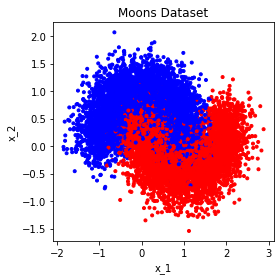

In [4]:
N_SAMPLES_TOT = 10_000

X, y = sklearn.datasets.make_moons(n_samples=N_SAMPLES_TOT, noise=0.3, random_state=0)

f, ax = plt.subplots(figsize=(4, 4))

ax.scatter(*X.T, c=y, marker=".", cmap="bwr")
ax.set_title("Moons Dataset")

ax.set_xlabel("x_1")
ax.set_ylabel("x_2")
    
f.tight_layout()

In [5]:
get_model = lambda: RandomForestClassifier(random_state=42)

N_SPLITS = 3
cv = StratifiedKFold(n_splits=N_SPLITS, random_state=0, shuffle=True)

N_INTIAL = 10
train_sizes = [N_INTIAL * 2**i for i in range(4)]

all_scores: dict[str, list] = defaultdict(list)

for i_split, (idx_train, idx_valid) in enumerate(cv.split(X, y)):
    
    print(f"{i_split+1}/{N_SPLITS}")
    
    X_train, y_train = X[idx_train], y[idx_train]
    X_valid, y_valid = X[idx_valid], y[idx_valid]
    
    
    # Fit model with RANDOM sampling
    print("- random sampling")
    scores = train_curve_random(X_train, y_train, X_valid, y_valid, get_model, train_sizes)
    all_scores["random sampling"].append(scores)
    
    
    # Fit model with ACTIVE LEARNING sampling
    for sampling_name, sampling_function in (
        ("uncertainty sampling", uncertainty_sampling),
        ("entropy sampling", entropy_sampling),
        ("margin sampling", margin_sampling),
    ):
        print(f"- {sampling_name}")
        scores = train_curve_active(X_train, y_train, X_valid, y_valid, get_model, train_sizes, sampling_function)
        all_scores[sampling_name].append(scores)


1/3
- random sampling
- uncertainty sampling
  - 10
  - 20
  - 40
  - 80
- entropy sampling
  - 10
  - 20
  - 40
  - 80
- margin sampling
  - 10
  - 20
  - 40
  - 80
2/3
- random sampling
- uncertainty sampling
  - 10
  - 20
  - 40
  - 80
- entropy sampling
  - 10
  - 20
  - 40
  - 80
- margin sampling
  - 10
  - 20
  - 40
  - 80
3/3
- random sampling
- uncertainty sampling
  - 10
  - 20
  - 40
  - 80
- entropy sampling
  - 10
  - 20
  - 40
  - 80
- margin sampling
  - 10
  - 20
  - 40
  - 80


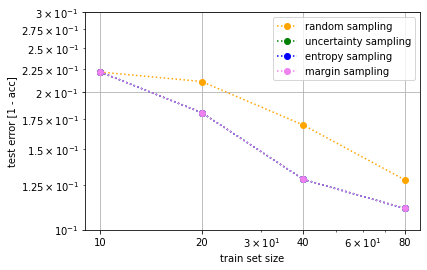

In [6]:
colors = {
    "random sampling": "orange",
    "uncertainty sampling": "green",
    "entropy sampling": "blue",
    "margin sampling": "violet",
}

f, ax = plt.subplots(figsize=(6,4))
for score_name, score_vals in all_scores.items():
    score_vals = np.array(score_vals)
    ax.loglog(train_sizes, 1-score_vals.mean(axis=0), 'o:', color=colors[score_name], label=score_name)


ax.grid()
ax.set_xticks(train_sizes);
ax.set_xticklabels(train_sizes);
ax.set_xlabel("train set size")
ax.set_ylabel("test error [1 - acc]")
ax.set_yticks([0.1, 0.2, 0.3])
ax.legend();

# Example: MNIST Dataset
This dataset is more complex, so we need more training samples to get a good accuracy.
We will only run the experiment on 1 split out of the 3 folds of the cross validation

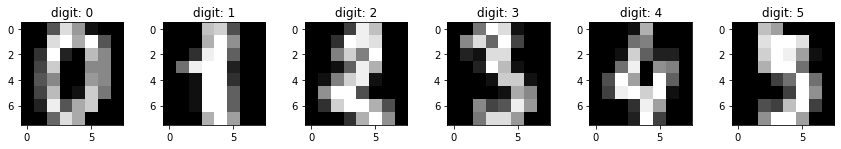

In [7]:
X, y = sklearn.datasets.load_digits(return_X_y=True)

n_digits_example = 6
f, ax = plt.subplots(1, n_digits_example, figsize=(2*n_digits_example, 2))
for i in range(n_digits_example):
    ax[i].imshow(X[i].reshape((8,8)), cmap="gray")
    ax[i].set_title(f"digit: {y[i]}")
    
f.tight_layout()

In [8]:
get_model = lambda: RandomForestClassifier(random_state=42)

cv = StratifiedKFold(n_splits=N_SPLITS, random_state=0, shuffle=True)

N_INTIAL = 100
train_sizes = [N_INTIAL * 2**i for i in range(3)]

all_scores: dict[str, list] = defaultdict(list)

idx_train, idx_valid = next(cv.split(X, y))
    

X_train, y_train = X[idx_train], y[idx_train]
X_valid, y_valid = X[idx_valid], y[idx_valid]


# Fit model with RANDOM sampling
print("- random sampling")
scores = train_curve_random(X_train, y_train, X_valid, y_valid, get_model, train_sizes)
all_scores["random sampling"] = scores


# Fit model with ACTIVE LEARNING sampling
for sampling_name, sampling_function in (
    ("uncertainty sampling", uncertainty_sampling),
    ("entropy sampling", entropy_sampling),
    ("margin sampling", margin_sampling),
):
    print(f"- {sampling_name}")
    scores = train_curve_active(X_train, y_train, X_valid, y_valid, get_model, train_sizes, sampling_function)
    all_scores[sampling_name] = scores


- random sampling
- uncertainty sampling
  - 100
  - 200
  - 400
- entropy sampling
  - 100
  - 200
  - 400
- margin sampling
  - 100
  - 200
  - 400


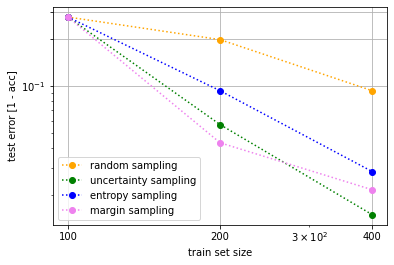

In [9]:
colors = {
    "random sampling": "orange",
    "uncertainty sampling": "green",
    "entropy sampling": "blue",
    "margin sampling": "violet",
}

f, ax = plt.subplots(figsize=(6,4))
for score_name, score_vals in all_scores.items():
    score_vals = np.array(score_vals)
    ax.loglog(train_sizes, 1-score_vals, 'o:', color=colors[score_name], label=score_name)


ax.grid()
ax.set_xticks(train_sizes);
ax.set_xticklabels(train_sizes);
ax.set_xlabel("train set size")
ax.set_ylabel("test error [1 - acc]")
ax.set_yticks([0.1, 0.2, 0.3])
ax.legend();